In [1]:
%matplotlib inline



# Coordinate-based meta-regression algorithms

A tour of Coordinate-based meta-regression (CBMR) algorithms in NiMARE

CBMR is a generative framework to approximate smooth activation intensity function
and investigate the effect of study-level moderators (e.g., year of pubilication,
sample size, subtype of stimuli). CBMR considers three stochastic models (Poisson,
Negative Binomial (NB) and Clustered NB) for modeling the random variation in foci,
and allows flexible statistical inference for either spatial homogeneity tests or
group comparison tests. It is a computationally efficient approach with
good statistical interpretability to model the locations of activation foci.

This tutorial is intended to provide a brief description and example of the CBMR
algorithm implemented in NiMARE.

For a more detailed introduction to the elements of a coordinate-based meta-regression,
see the [online course](https://www.coursera.org/lecture/functional-mri-2/module-3-meta-analysis-Vd4zz)
or a [brief overview](https://libguides.princeton.edu/neuroimaging_meta).


In [2]:
import numpy as np
import scipy
from nilearn.plotting import plot_stat_map

from nimare.generate import create_coordinate_dataset
from nimare.meta import models
from nimare.transforms import StandardizeField

## Load Dataset
Here, we're going to simulate a dataset 
(using [nimare.generate.create_coordinate_dataset](https://nimare.readthedocs.io/en/latest/generated/nimare.generate.create_coordinate_dataset.html))
that includes 100 studies, each with 10 reported foci and sample size varying between
20 and 40. We separate them into four groups according to diagnosis (schizophrenia or depression)
and drug status (Yes or No). We also add two continuous study-level moderators (sample size and 
average age) and a categorical study-level moderator (schizophrenia subtype).



In [3]:
# data simulation
ground_truth_foci, dset = create_coordinate_dataset(foci=10, sample_size=(20, 40), n_studies=1000)
# set up group columns: diagnosis & drug_status
n_rows = dset.annotations.shape[0]
dset.annotations["diagnosis"] = [
    "schizophrenia" if i % 2 == 0 else "depression" for i in range(n_rows)
]
dset.annotations["drug_status"] = ["Yes" if i % 2 == 0 else "No" for i in range(n_rows)]
dset.annotations["drug_status"] = (
    dset.annotations["drug_status"].sample(frac=1).reset_index(drop=True)
)  # random shuffle drug_status column
# set up continuous moderators: sample sizes & avg_age
dset.annotations["sample_sizes"] = [dset.metadata.sample_sizes[i][0] for i in range(n_rows)]
dset.annotations["avg_age"] = np.arange(n_rows)
# set up categorical moderators: schizophrenia_subtype (as not enough data to be interpreted
# as groups)
dset.annotations["schizophrenia_subtype"] = ["type1", "type2", "type3", "type4", "type5"] * int(
    n_rows / 5
)
dset.annotations["schizophrenia_subtype"] = (
    dset.annotations["schizophrenia_subtype"].sample(frac=1).reset_index(drop=True)
)  # random shuffle drug_status column

## Estimation of group-specific spatial intensity functions
CBMR can generate estimation of group-specific spatial internsity
functions for multiple groups simultaneously, with different group-specific
spatial regression coefficients.

CBMR can also consider the effects of study-level moderators
(e.g. sample size, year of publication) by estimating regression coefficients
of moderators (shared by all groups).

Note that study-level moderators can only have global effects instead of localized
effects within CBMR framework. In the scenario that there're multiple subgroups
within a group (e.g., indexed as subgroup-1 to subgroup-n, but one or more of them
don't have enough number of studies to be inferred as a separate group). Using
categorical encoding, CBMR can interpret the subgroups as categorical moderators
for each study (either 0 or 1), and estimate the global activation intensity 
associated with each subgroup (comparing to the average).



In [4]:
from nimare.meta.cbmr import CBMREstimator

dset = StandardizeField(fields=["sample_sizes", "avg_age"]).transform(dset)

cbmr = CBMREstimator(
    group_categories=["diagnosis", "drug_status"],
    moderators=[
        "standardized_sample_sizes",
        "standardized_avg_age",
        "schizophrenia_subtype:reference=type1",
    ],
    spline_spacing=100,  # a reasonable choice is 10 or 5, 100 is for speed
    model=models.PoissonEstimator,
    penalty=False,
    lr=1e-1,
    tol=1e3, # a reasonable choice is 1e-2, 1e3 is for speed
    device="cpu", # "cuda" if you have GPU
)
results = cbmr.fit(dataset=dset)

INFO:nimare.diagnostics:0/10000 coordinates fall outside of the mask. Removing them.


Now that we have fitted the model, we can plot the spatial intensity maps.



/well/nichols/users/pra123/anaconda3/envs/torch/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


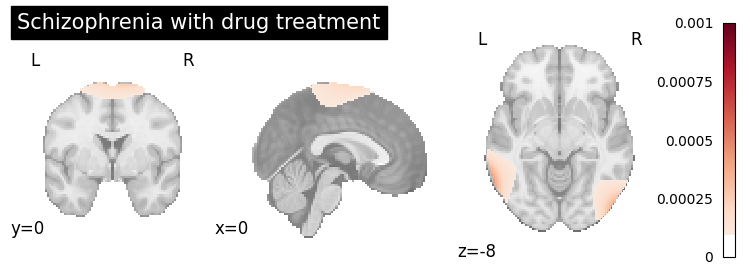

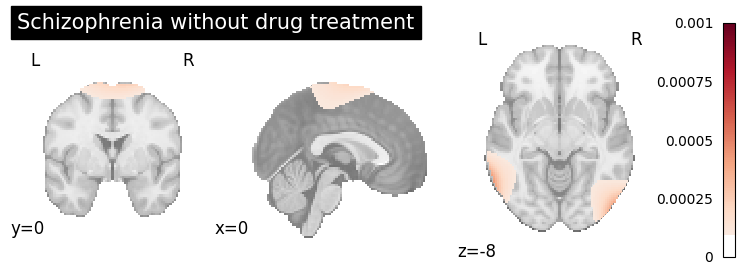

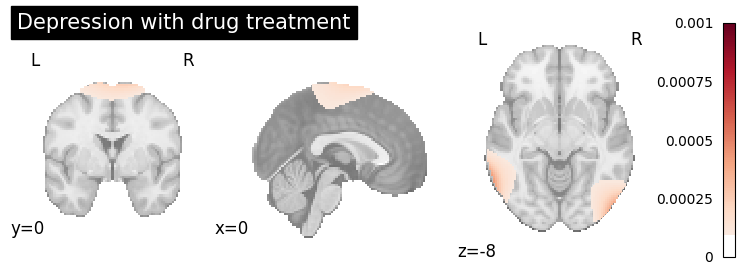

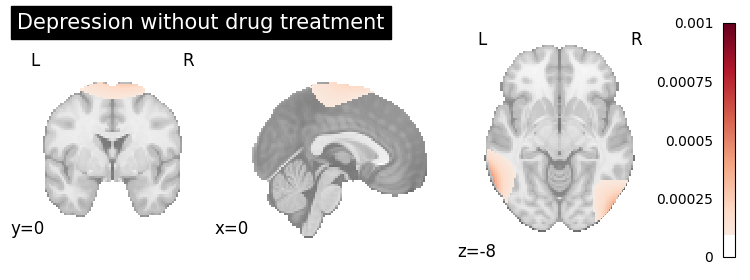

In [5]:
plot_stat_map(
    results.get_map("spatialIntensity_group-SchizophreniaYes"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Schizophrenia with drug treatment",
    threshold=1e-4,
    vmax=1e-3,
)
plot_stat_map(
    results.get_map("spatialIntensity_group-SchizophreniaNo"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Schizophrenia without drug treatment",
    threshold=1e-4,
    vmax=1e-3,
)
plot_stat_map(
    results.get_map("spatialIntensity_group-DepressionYes"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Depression with drug treatment",
    threshold=1e-4,
    vmax=1e-3,
)
plot_stat_map(
    results.get_map("spatialIntensity_group-DepressionNo"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Depression without drug treatment",
    threshold=1e-4,
    vmax=1e-3,
)

Four figures correspond to group-specific spatial intensity map of four groups
("schizophreniaYes", "schizophreniaNo", "depressionYes", "depressionNo").
Areas with stronger spatial intensity are highlighted.



## Generalized Linear Hypothesis (GLH) testing for spatial homogeneity
In the most basic scenario of spatial homogeneity test, contrast matrix `t_con_groups`
can be generated by `create_contrast` function, with group names specified.



In [6]:
from nimare.meta.cbmr import CBMRInference

inference = CBMRInference(device="cuda")
inference.fit(result=results)
t_con_groups = inference.create_contrast(
    ["SchizophreniaYes", "SchizophreniaNo", "DepressionYes", "DepressionNo"], source="groups"
)
contrast_result = inference.transform(t_con_groups=t_con_groups)

INFO:nimare.meta.cbmr:standardized_sample_sizes = index_0
INFO:nimare.meta.cbmr:standardized_avg_age = index_1
INFO:nimare.meta.cbmr:type2 = index_2
INFO:nimare.meta.cbmr:type3 = index_3
INFO:nimare.meta.cbmr:type4 = index_4
INFO:nimare.meta.cbmr:type5 = index_5


Now that we have done spatial homogeneity tests, we can plot the z-score maps.



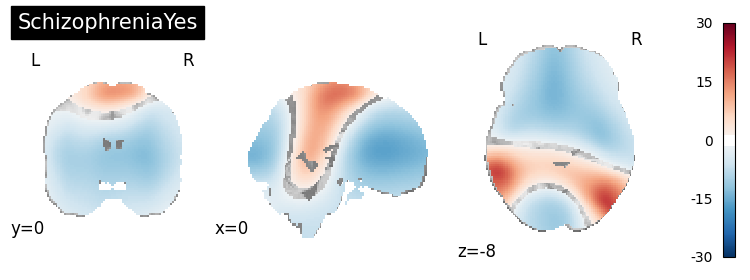

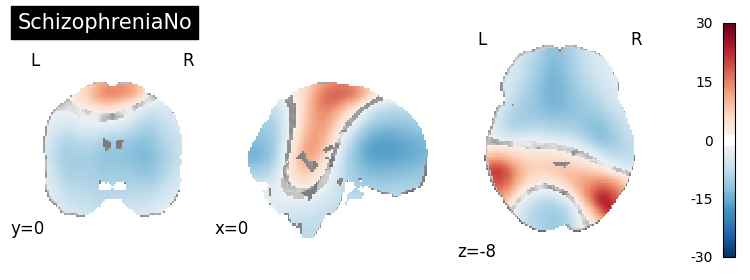

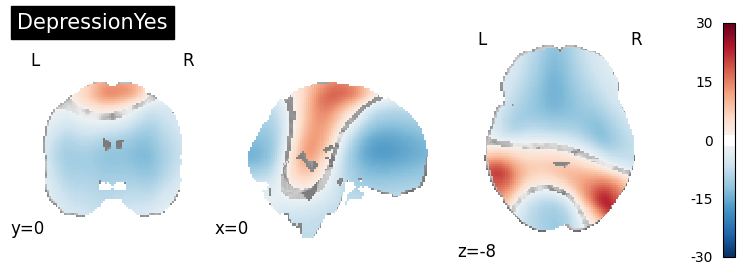

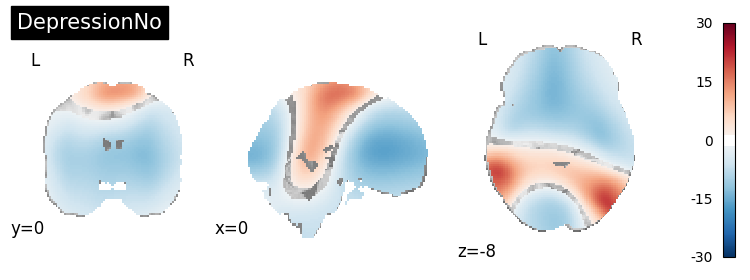

In [7]:
# generate z-score maps for group-wise spatial homogeneity test
plot_stat_map(
    contrast_result.get_map("z_group-SchizophreniaYes"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="SchizophreniaYes",
    threshold=scipy.stats.norm.isf(0.05),
    vmax=30,
)

plot_stat_map(
    contrast_result.get_map("z_group-SchizophreniaNo"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="SchizophreniaNo",
    threshold=scipy.stats.norm.isf(0.05),
    vmax=30,
)

plot_stat_map(
    contrast_result.get_map("z_group-DepressionYes"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="DepressionYes",
    threshold=scipy.stats.norm.isf(0.05),
    vmax=30,
)

plot_stat_map(
    contrast_result.get_map("z_group-DepressionNo"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="DepressionNo",
    threshold=scipy.stats.norm.isf(0.05),
    vmax=30,
)

Four figures (displayed as z-statistics map) correspond to homogeneity test of
group-specific spatial intensity for four groups. The null hypothesis assumes
homogeneous spatial intensity over the whole brain,
$H_0: \mu_j = \mu_0 = sum(n_{\text{foci}})/N$, $j=1, \cdots, N$, where $N$ is
the number of voxels within brain mask, $j$ is the index of voxel. Areas with
significant p-values are highlighted (under significance level $0.05$).



## Perform fasle discovery rate (FDR) correction on spatial homogeneity test
The default FDR correction method is "indep", using Benjamini-Hochberg(BH) procedure.



In [8]:
from nimare.correct import FDRCorrector

corr = FDRCorrector(method="indep", alpha=0.05)
cres = corr.transform(contrast_result)

Now that we have applied the FDR correction methods,
we can plot the FDR corrected z-score maps.



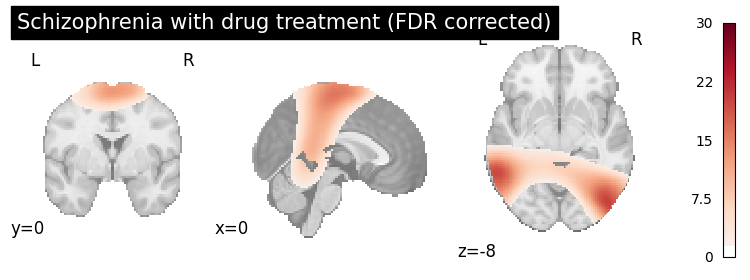

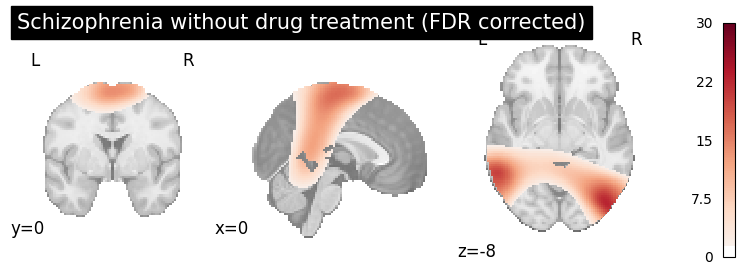

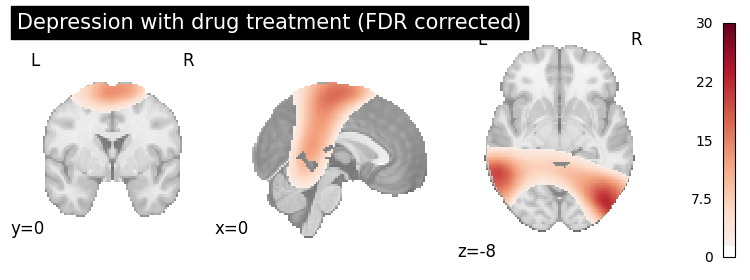

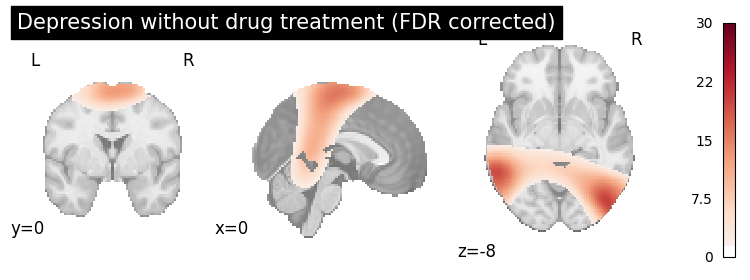

In [9]:
# generate FDR corrected z-score maps for group-wise spatial homogeneity test
plot_stat_map(
    cres.get_map("z_group-SchizophreniaYes_corr-FDR_method-indep"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Schizophrenia with drug treatment (FDR corrected)",
    threshold=scipy.stats.norm.isf(0.05),
    vmax=30,
)

plot_stat_map(
    cres.get_map("z_group-SchizophreniaNo_corr-FDR_method-indep"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Schizophrenia without drug treatment (FDR corrected)",
    threshold=scipy.stats.norm.isf(0.05),
    vmax=30,
)

plot_stat_map(
    cres.get_map("z_group-DepressionYes_corr-FDR_method-indep"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Depression with drug treatment (FDR corrected)",
    threshold=scipy.stats.norm.isf(0.05),
    vmax=30,
)

plot_stat_map(
    cres.get_map("z_group-DepressionNo_corr-FDR_method-indep"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Depression without drug treatment (FDR corrected)",
    threshold=scipy.stats.norm.isf(0.05),
    vmax=30,
)

After FDR correction (via BH procedure), areas with stronger spatial intensity
are more stringent, (the number of voxels with significant p-values is reduced).



## GLH testing for group comparisons among any two groups
In the most basic scenario of group comparison test, contrast matrix `t_con_groups`
can be generated by `create_contrast` function, with `contrast_name` specified as
"group1-group2".



In [10]:
t_con_groups = inference.create_contrast(
    [
        "SchizophreniaYes-SchizophreniaNo",
        "SchizophreniaNo-DepressionNo",
        "DepressionYes-DepressionNo",
    ],
    source="groups",
)
contrast_result = inference.transform(t_con_groups=t_con_groups, t_con_moderators=False)

Now that we have done group comparison tests,
we can plot the z-score maps indicating difference in spatial intensity between two groups.



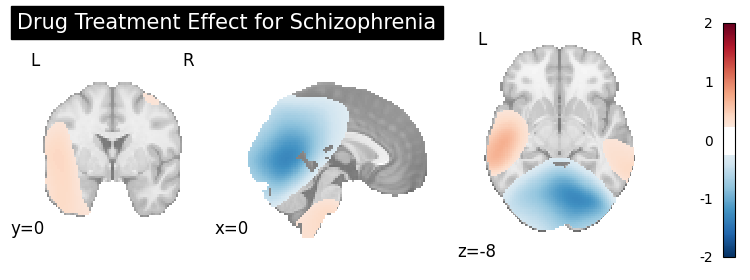

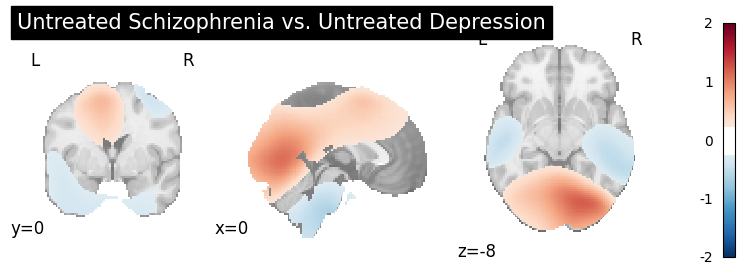

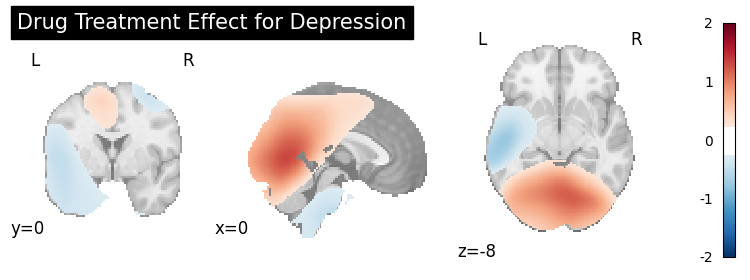

In [11]:
# generate z-statistics maps for each group
plot_stat_map(
    contrast_result.get_map("z_group-SchizophreniaYes-SchizophreniaNo"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Drug Treatment Effect for Schizophrenia",
    threshold=scipy.stats.norm.isf(0.4),
    vmax=2,
)

plot_stat_map(
    contrast_result.get_map("z_group-SchizophreniaNo-DepressionNo"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Untreated Schizophrenia vs. Untreated Depression",
    threshold=scipy.stats.norm.isf(0.4),
    vmax=2,
)

plot_stat_map(
    contrast_result.get_map("z_group-DepressionYes-DepressionNo"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Drug Treatment Effect for Depression",
    threshold=scipy.stats.norm.isf(0.4),
    vmax=2,
)

Four figures (displayed as z-statistics map) correspond to group comparison
test of spatial intensity for any two groups. The null hypothesis assumes
spatial intensity estimations of two groups are equal at voxel level,
$H_0: \mu_{1j}=\mu_{2j}$, $j=1, \cdots, N$, where $N$ is the number of voxels
within brain mask, $j$ is the index of voxel. Areas with significant p-values
(significant difference in spatial intensity estimation between two groups)
are highlighted (under significance level $0.05$).



## GLH testing with contrast matrix specified
CBMR supports more flexible GLH test by specifying a contrast matrix.
For example, group comparison test `2xgroup_0-1xgroup_1-1xgroup_2` can be
represented as `t_con_group=[2, -1, -1, 0]`, as an input in `compute_contrast`
function. Multiple independent GLH tests can be conducted simultaneously by
including multiple contrast vectors/matrices in `t_con_group`.

CBMR also allows simultaneous GLH tests (consisting of multiple contrast vectors)
when it's represented as one of elements in `t_con_group` (datatype: list).
Only if all of null hypotheses are rejected at voxel level, p-values are significant.
For example, `t_con_group=[[1,-1,0,0], [1,0,-1,0], [0,0,1,-1]]` is used for testing
the equality of spatial intensity estimation among all of four groups (finding the
consistent activation regions). Note that only $n-1$ contrast vectors are necessary
for testing the equality of $n$ groups.



In [12]:
contrast_result = inference.transform(
    t_con_groups=[[[1, -1, 0, 0], [1, 0, -1, 0], [0, 0, 1, -1]]], t_con_moderators=False
)

Now that we have done group comparison tests with the specified contrast matrix,
we can plot the z-score maps indicating consistency in activation regions among
all four groups.



The contrast matrix of GLH_0 is [[1, -1, 0, 0], [1, 0, -1, 0], [0, 0, 1, -1]]


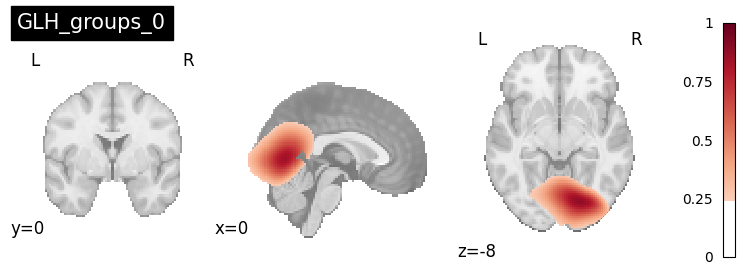

In [13]:
plot_stat_map(
    contrast_result.get_map("z_GLH_groups_0"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="GLH_groups_0",
    threshold=scipy.stats.norm.isf(0.4),
)
print("The contrast matrix of GLH_0 is {}".format(contrast_result.metadata["GLH_groups_0"]))

## GLH testing for study-level moderators
CBMR framework can estimate global study-level moderator effects,
and allows inference on the existence of m.



In [14]:
contrast_name = results.estimator.moderators
t_con_moderators = inference.create_contrast(contrast_name, source="moderators")
contrast_result = inference.transform(t_con_moderators=t_con_moderators)
print(contrast_result.tables["moderators_regression_coef"])
print(
    "P-values of moderator effects `sample_sizes` is {}".format(
        contrast_result.tables["p_standardized_sample_sizes"]
    )
)
print(
    "P-value of moderator effects `avg_age` is {}".format(
        contrast_result.tables["p_standardized_avg_age"]
    )
)

   standardized_sample_sizes  standardized_avg_age     type2    type3  \
0                  -0.000769              0.005946  0.107031  0.08795   

      type4     type5  
0  0.105989  0.090762  
P-values of moderator effects `sample_sizes` is           p
0  0.939472
P-value of moderator effects `avg_age` is           p
0  0.557174


This table shows the regression coefficients of study-level moderators, here,
`sample_sizes` and `avg_age` are standardized in the preprocessing steps.
Moderator effects of both `sample_size` and `avg_age` are not significant under
significance level $0.05$. With reference to spatial intensity estimation of
a chosen subtype, spatial intensity estimations of the other $4$ subtypes of
schizophrenia are moderatored globally.



In [15]:
t_con_moderators = inference.create_contrast(
    ["standardized_sample_sizes-standardized_avg_age"], source="moderators"
)
contrast_result = inference.transform(t_con_moderators=t_con_moderators)
print(
    "P-values of difference in two moderator effectors (`sample_size-avg_age`) is {}".format(
        contrast_result.tables["p_standardized_sample_sizes-standardized_avg_age"]
    )
)

P-values of difference in two moderator effectors (`sample_size-avg_age`) is           p
0  0.639232


CBMR also allows flexible contrasts between study-level covariates.
For example, we can write `contrast_name` (an input to `create_contrast`
function) as `standardized_sample_sizes-standardized_avg_age` when exploring
if the moderator effects of `sample_sizes` and `avg_age` are equivalent.

